In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 2 to use

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')
# tf.debugging.set_log_device_placement(False)

2024-06-28 22:02:36.669404: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 22:02:36.921270: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 22:02:36.921305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 22:02:36.922533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-28 22:02:37.029428: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1


2024-06-28 22:02:40.063579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 22:02:40.186521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 22:02:40.186677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import keras
import os
from PIL import Image
import numpy as np
import cv2

In [4]:
image_path = './data/'
img_list = os.listdir(image_path)
img_png = [img for img in img_list]
img_png.sort()
print(img_png)

['7d_1.jpg', '7d_10.jpg', '7d_2.jpg', '7d_3.jpg', '7d_4.jpg', '7d_5.jpg', '7d_8.jpg', '7d_9.jpg']


In [5]:
import cv2

train_image_list=[]
train_label_list=[]
for file in img_png:
    img = Image.open(image_path+file)
    img = np.array(img)
    img = cv2.resize(img, (200, 200), cv2.INTER_AREA)
    train_image_list.append(np.array(img))
    
    img = Image.open("./filter/"+file[:-3]+"png")
    img = np.array(img)
    img = cv2.resize(img, (200, 200), img, cv2.INTER_AREA)
    train_label_list.append(np.array(img))

train_image = np.array(train_image_list)
train_label = np.array(train_label_list)

In [6]:
print(train_image.shape)
print(train_label.shape)

(8, 200, 200, 3)
(8, 200, 200, 4)


In [7]:
print(max(train_image[0].reshape(-1)))
print(min(train_image[0].reshape(-1)))
print(max(train_label[0].reshape(-1)))
print(min(train_label[0].reshape(-1)))

255
0
255
0


In [8]:
train_image = train_image / 255
train_label = train_label / 255

In [9]:
print(max(train_image[0].reshape(-1)))
print(min(train_image[0].reshape(-1)))
print(max(train_label[0].reshape(-1)))
print(min(train_label[0].reshape(-1)))

1.0
0.0
1.0
0.0


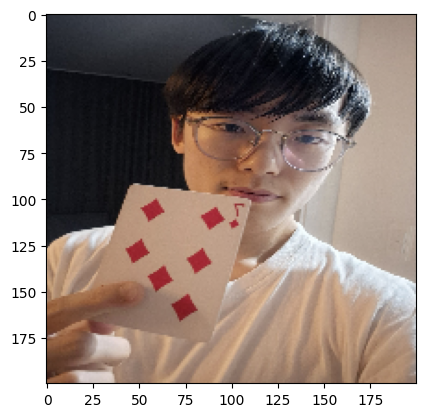

In [10]:
import matplotlib.pyplot as plt
plt.imshow(train_image[0])
plt.show()

In [11]:
min(train_label[train_label>0])

0.00392156862745098

In [12]:
train_label[train_label > 0.5] = 1
train_label[train_label <= 0.5] = 0
min(train_label[train_label>0])

1.0

In [13]:
train_label = train_label[...,:1]
train_label.shape

(8, 200, 200, 1)

In [14]:
train_label.shape

(8, 200, 200, 1)

In [15]:
label_color = cv2.cvtColor(train_label[0].astype(np.float32), cv2.COLOR_GRAY2BGR)
print(label_color.shape)
print(train_image[0,...].shape)

(200, 200, 3)
(200, 200, 3)


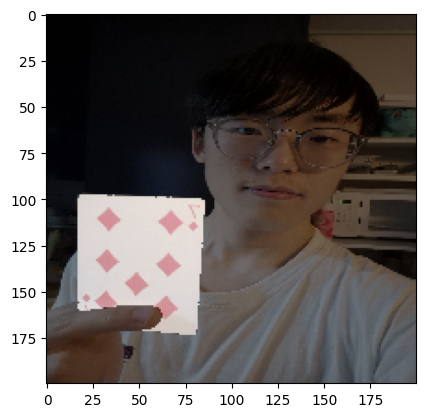

In [16]:
label_color = cv2.cvtColor(train_label[5].astype(np.float32), cv2.COLOR_GRAY2BGR)
showImg = cv2.addWeighted(train_image[5,...].astype(np.float32), 0.5, label_color, 0.5, 0)

plt.imshow(showImg)
plt.show()

In [65]:
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Conv2DTranspose, Cropping2D, Concatenate
from keras.models import Model
from keras.activations import sigmoid

input = Input(shape=(200,200,3))
c_1_1 = Conv2D(32,(3,3),padding="same",activation="relu")(input)
c_1_2 = Conv2D(32,(3,3),padding="same",activation="relu")(c_1_1)
c_2_1 = MaxPool2D()(c_1_2)

c_2_2 = Conv2D(64,(3,3), padding="same",activation="relu")(c_2_1)
c_2_3 = Conv2D(64,(3,3), padding="same",activation="relu")(c_2_2)
c_3_1 = MaxPool2D()(c_2_3)

c_3_2 = Conv2D(128,(3,3), padding="same",activation="relu")(c_3_1)
c_3_3 = Conv2D(128,(3,3), padding="same",activation="relu", name="third")(c_3_2)
c_4_1 = MaxPool2D()(c_3_3)

c_4_2 = Conv2D(256,(3,3), padding="same",activation="relu")(c_4_1)
c_4_3 = Conv2D(256,(3,3), padding="same",activation="relu")(c_4_2)

c_5_1 = Conv2DTranspose(128, (3,3), strides=(2,2))(c_4_3)
c_5_2 = Cropping2D(cropping=((0,1),(0,1)))(c_5_1)
c_5_3 = Concatenate()([c_5_2, c_3_3])
c_5_4 = Conv2D(128,(3,3),padding="same",activation="relu")(c_5_3)
c_5_5 = Conv2D(128,(3,3),padding="same",activation="relu")(c_5_4)

c_6_1 = Conv2DTranspose(64, (3,3), strides=(2,2))(c_5_5)
c_6_2 = Cropping2D(cropping=((0,1),(0,1)))(c_6_1)
c_6_3 = Concatenate()([c_6_2, c_2_3])
c_6_4 = Conv2D(64,(3,3),padding="same",activation="relu")(c_6_3)
c_6_5 = Conv2D(64,(3,3),padding="same",activation="relu")(c_6_4)

c_7_1 = Conv2DTranspose(32, (3,3), strides=(2,2))(c_6_5)
c_7_2 = Cropping2D(cropping=((0,1),(0,1)))(c_7_1)
c_7_3 = Concatenate()([c_7_2, c_1_2])
c_7_4 = Conv2D(32,(3,3),padding="same",activation="relu")(c_7_3)
c_7_5 = Conv2D(32,(3,3),padding="same",activation="relu")(c_7_4)

c_8_1 = Conv2D(10,(3,3),padding="same",activation="relu")(c_7_5)
c_8_2 = Conv2D(1,(1,1),padding="same",activation="sigmoid")(c_8_1)

model = Model(input, c_8_2)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_119 (Conv2D)         (None, 200, 200, 32)         896       ['input_9[0][0]']             
                                                                                                  
 conv2d_120 (Conv2D)         (None, 200, 200, 32)         9248      ['conv2d_119[0][0]']          
                                                                                                  
 max_pooling2d_24 (MaxPooli  (None, 100, 100, 32)         0         ['conv2d_120[0][0]']          
 ng2D)                                                                                      

In [66]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [67]:
print(train_image.shape)
print(train_image[:-1].shape)

(8, 200, 200, 3)
(7, 200, 200, 3)


In [68]:
hist = model.fit(train_image[:1], train_label[:1], epochs=150, verbose=2)

Epoch 1/150


1/1 - 3s - loss: 0.6947 - 3s/epoch - 3s/step
Epoch 2/150
1/1 - 0s - loss: 0.6754 - 111ms/epoch - 111ms/step
Epoch 3/150
1/1 - 0s - loss: 0.6526 - 67ms/epoch - 67ms/step
Epoch 4/150
1/1 - 0s - loss: 0.6154 - 15ms/epoch - 15ms/step
Epoch 5/150
1/1 - 0s - loss: 0.5502 - 17ms/epoch - 17ms/step
Epoch 6/150
1/1 - 0s - loss: 0.4686 - 13ms/epoch - 13ms/step
Epoch 7/150
1/1 - 0s - loss: 0.6114 - 25ms/epoch - 25ms/step
Epoch 8/150
1/1 - 0s - loss: 0.4633 - 25ms/epoch - 25ms/step
Epoch 9/150
1/1 - 0s - loss: 0.4706 - 14ms/epoch - 14ms/step
Epoch 10/150
1/1 - 0s - loss: 0.4799 - 13ms/epoch - 13ms/step
Epoch 11/150
1/1 - 0s - loss: 0.4800 - 15ms/epoch - 15ms/step
Epoch 12/150
1/1 - 0s - loss: 0.4725 - 20ms/epoch - 20ms/step
Epoch 13/150
1/1 - 0s - loss: 0.4608 - 13ms/epoch - 13ms/step
Epoch 14/150
1/1 - 0s - loss: 0.4512 - 21ms/epoch - 21ms/step
Epoch 15/150
1/1 - 0s - loss: 0.4556 - 13ms/epoch - 13ms/step
Epoch 16/150
1/1 - 0s - loss: 0.4473 - 13ms/epoch - 13ms/step
Epoch 17/150
1/1 - 0s - loss: 0

dict_keys(['loss'])


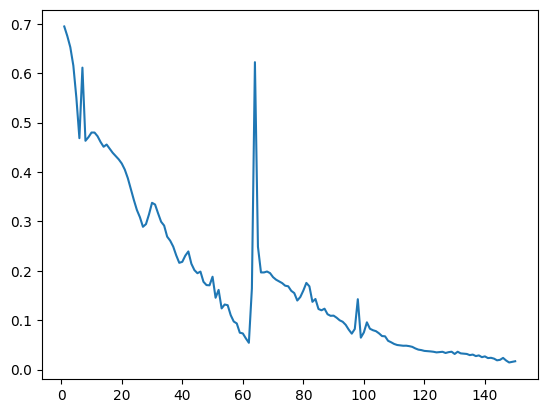

In [73]:
print(hist.history.keys())
loss = hist.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss)

In [77]:
value = model.predict(train_image[1:2])


1/1 [==============================] - 0s 26ms/step


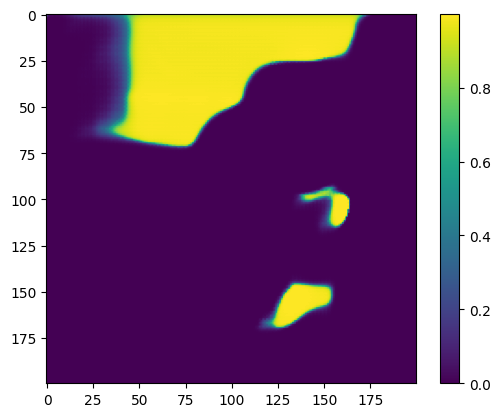

In [78]:
plt.imshow(value[0])
plt.colorbar()
plt.show()

In [49]:
value.reshape(-1).max()

0.4774543

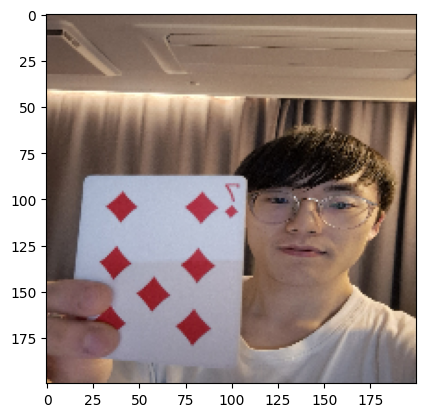

In [79]:
plt.imshow(train_image[1])
plt.show()